<a href="https://colab.research.google.com/github/c-mmonteiro/t1-algo-feature/blob/main/Trabaho1_MI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mutual Information


## 1. Conjunto de Dados

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### 1.1 Importa os dados

In [1]:
import pandas as pd
import numpy as np

#dados_petr = pd.read_csv("/content/drive/MyDrive/Colab/Caracteristicas_Tudo_PETR4_25894_FROM_2018_09_28_TO_2025_04_01.csv")
dados = pd.read_csv("TI_PETR4_2520_FROM_2018_09_28_TO_2023_09_28.csv")
dados

,SMA,WMA,Momentum,StochasticD,StochasticK,Williams,RSI,MACD,ADO,CCI,rendimento
0,9.412,9.344909,-0.74,21.076522,29.012346,70.987654,54.005401,0.179328,-1.117647,11.743451,-3.138075
1,9.340,9.320909,-0.39,19.671494,35.507246,64.492754,53.357558,0.153804,0.909091,34.092964,0.215983
2,9.272,9.257273,-0.33,19.375227,17.391304,82.608696,52.778561,0.125887,-0.448276,-36.242981,-3.125000
3,9.235,9.198727,-0.41,22.354123,18.181818,81.818182,52.455634,0.096954,0.657143,-26.258457,-0.444939
4,9.241,9.232364,0.10,29.193214,71.590909,28.409091,52.422907,0.075394,1.019231,70.175439,5.251397
...,...,...,...,...,...,...,...,...,...,...,...
1196,33.095,33.333636,1.93,89.052009,103.645833,-3.645833,53.927187,0.942278,1.077778,81.925622,2.543143
1197,33.290,33.478182,1.26,91.268977,94.607843,5.392157,53.953770,0.949702,0.315789,82.076325,0.059049
1198,33.440,33.630909,1.84,92.546958,107.262570,-7.262570,53.973585,0.957619,0.953488,88.053217,0.708174
1199,33.632,33.770909,0.84,92.499710,79.919679,20.080321,54.000478,0.964643,0.890909,84.366172,0.234398


### 1.2 Gráficos dos dados em relação ao Rendimento

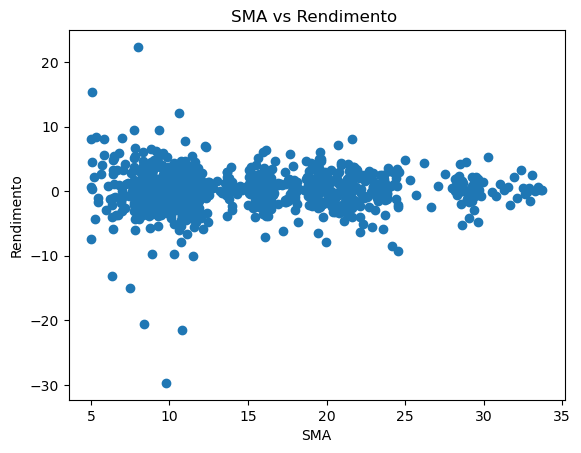

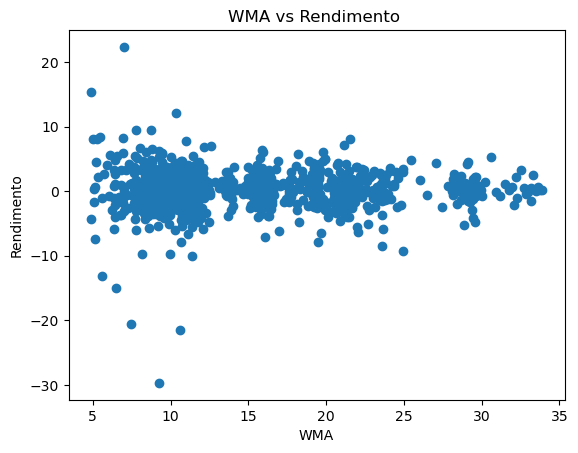

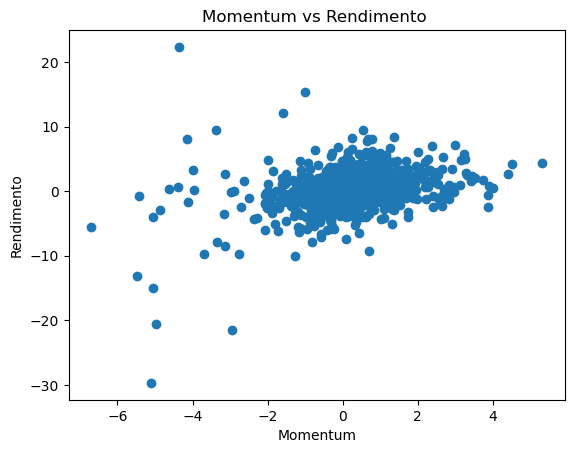

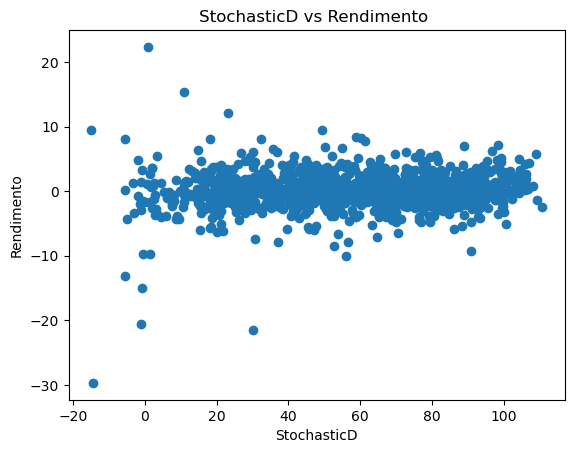

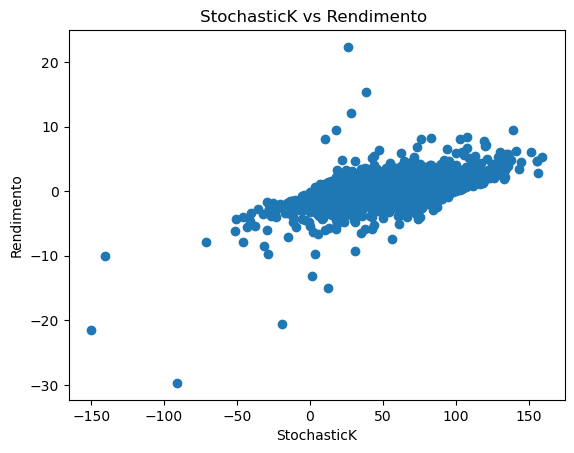

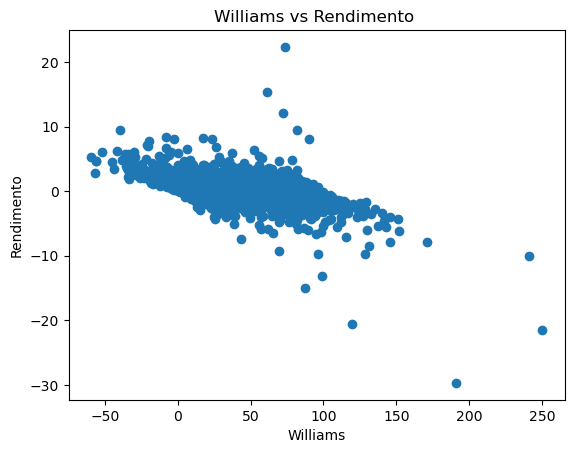

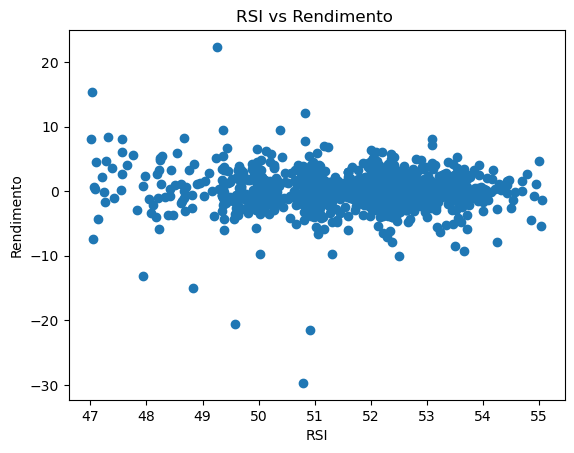

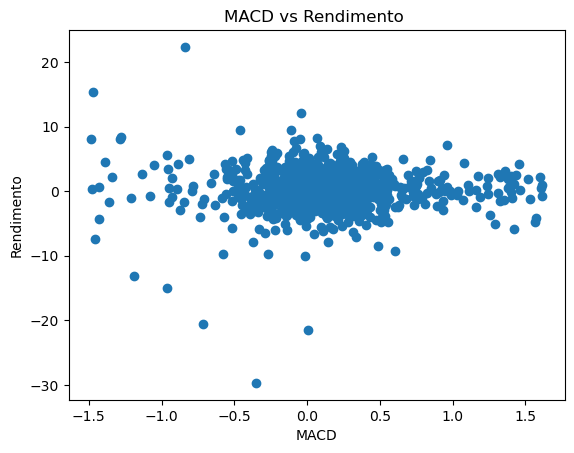

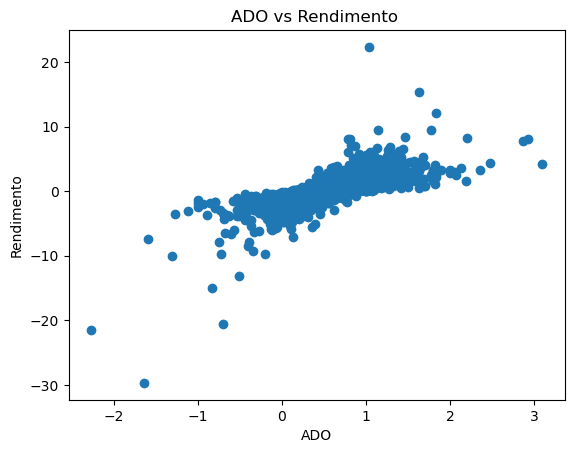

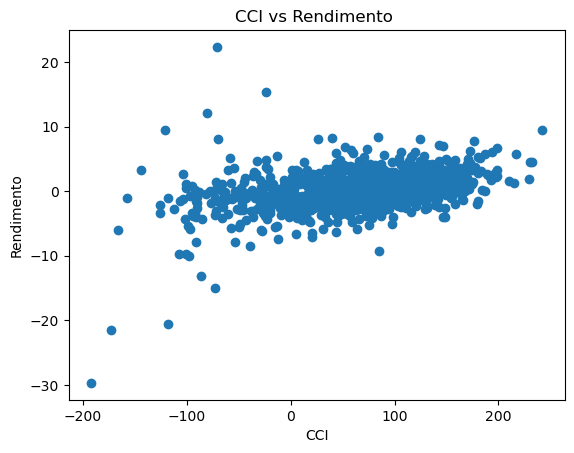

In [2]:
from matplotlib import pyplot as plt
colunas = dados.columns[:-1]

for idx, col in enumerate(colunas):
    plt.plot(dados[col], dados['rendimento'], 'o')
    plt.title(f'{col} vs Rendimento ')
    plt.xlabel(col)
    plt.ylabel('Rendimento')
    plt.show()

### 1.3 Histograma dos dados

In [3]:
def determina_bins(x, bins_rule = 'fd'):
    if bins_rule == 'classic':
        bins = int(len(x)**0.5)
    elif bins_rule == 'sturges':
        bins = int(np.ceil(np.log2(len(x)) + 1))
    elif bins_rule == 'scott': #ótima para distribuição normal
        bins = int((np.max(x) - np.min(x)) / (3.5 * np.std(x) * len(x)**(-1/3)))
    elif bins_rule == 'fd': #mais robusta para outliers
        bins = int((np.max(x) - np.min(x)) / (2 * (np.percentile(x, 75) - np.percentile(x, 25)) * len(x)**(-1/3)))        
    
    return bins

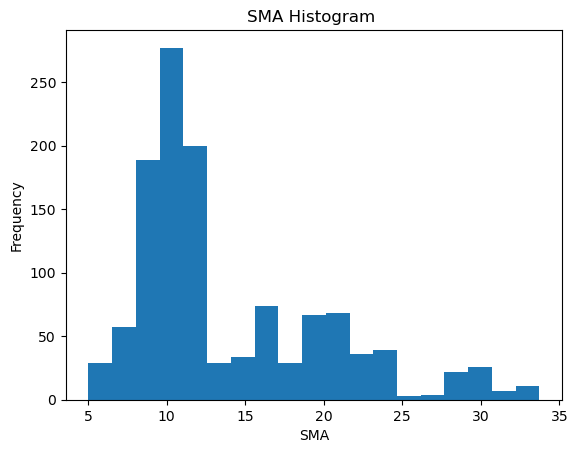

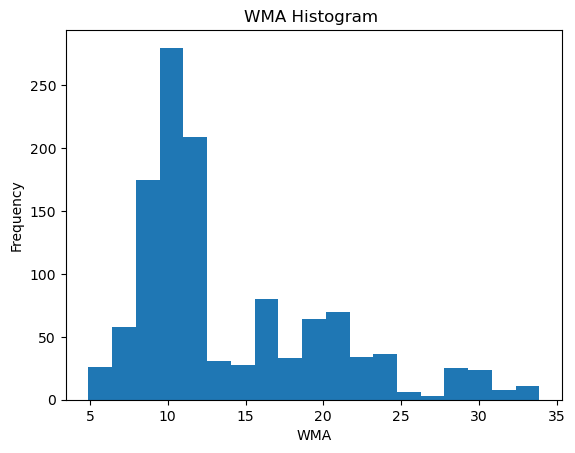

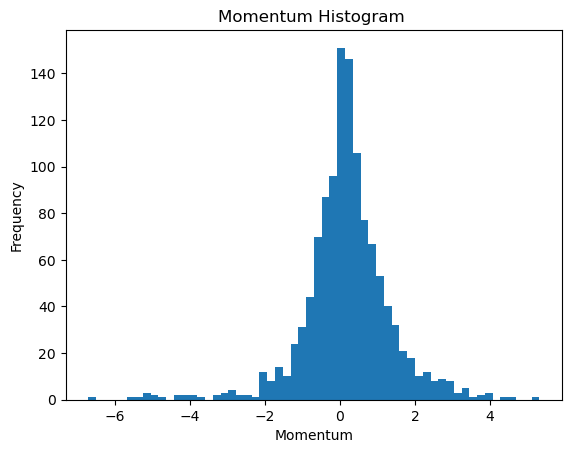

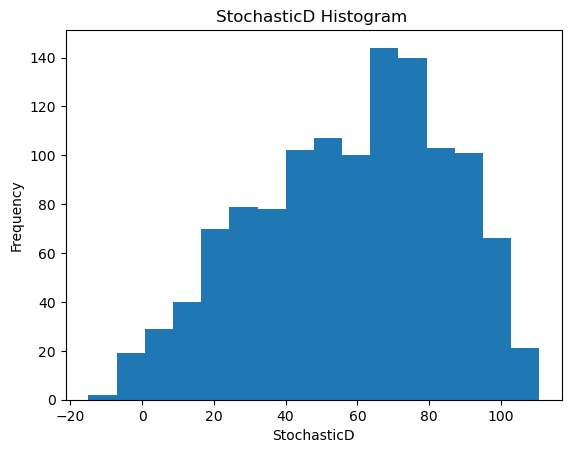

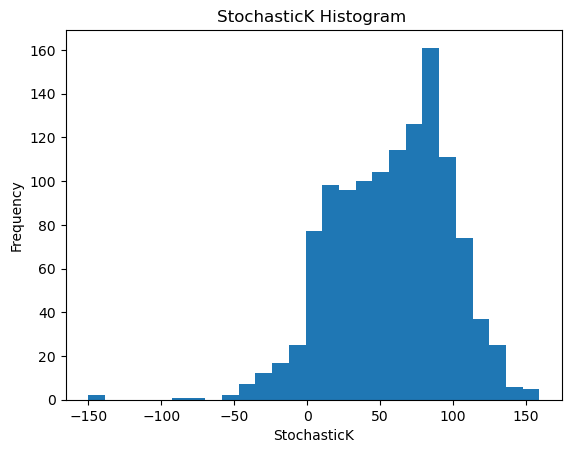

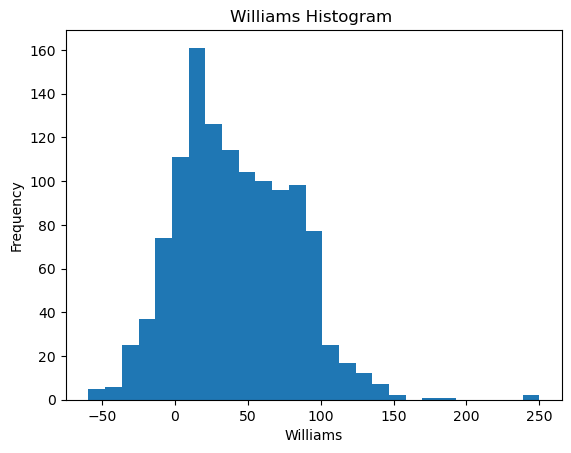

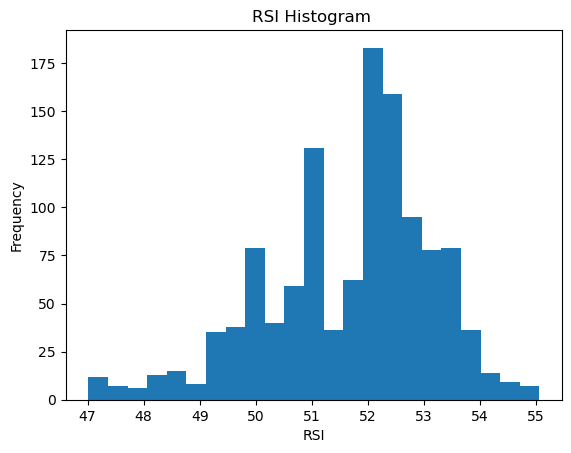

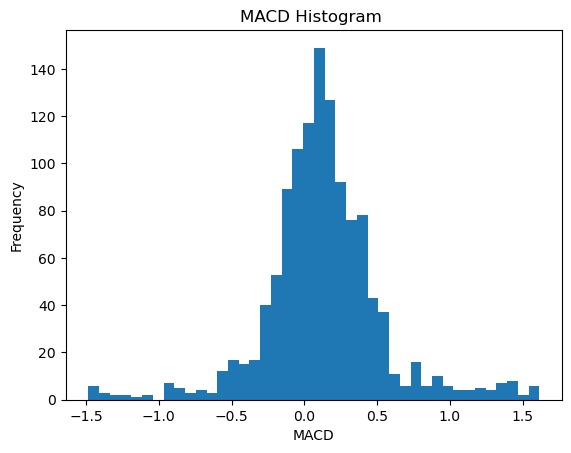

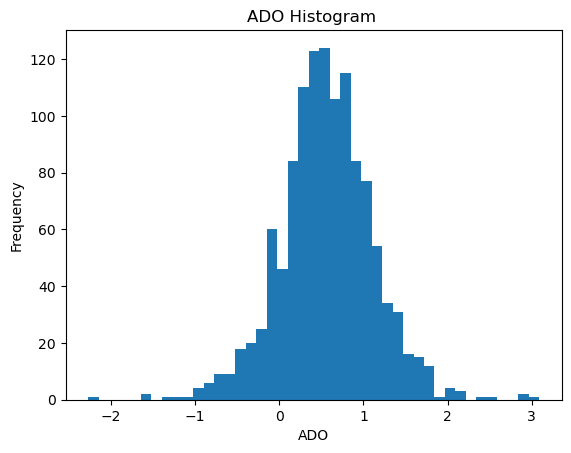

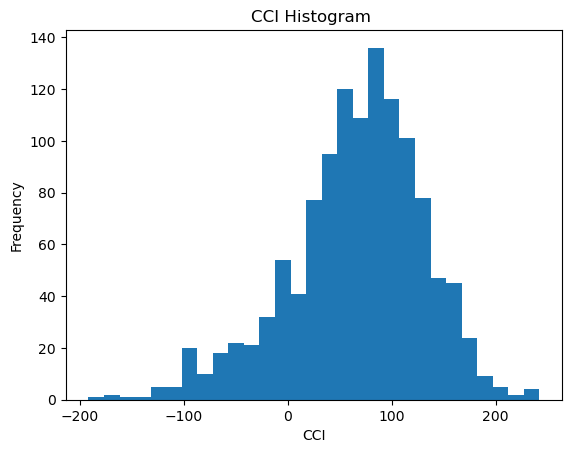

In [4]:
from matplotlib import pyplot as plt
colunas = dados.columns[:-1]

for idx, col in enumerate(colunas):
    plt.hist(dados[col], bins=determina_bins(dados[col]))
    plt.title(f'{col} Histogram ')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

##  2. Modifiações nos dados

### 2.1 Converte os dados para distribuição

In [5]:
import numpy as np
import bisect

def converte_bins(x):
    '''
    Converte a coluna x em bins discretos.
    Parâmetros:
    x: array-like, coluna a ser convertida.
    bins: int, número de bins.
    Retorna:
    array-like, coluna
    '''
    edge = np.linspace(x.min(), x.max(), determina_bins(x)+1)

    x_bins = []
    for xi in x:
      x_bins.append(bisect.bisect_left(edge, xi))
    return x_bins

In [7]:
dados_bins = pd.DataFrame()
for col in colunas:
    dados_bins[col] = converte_bins(dados[col])
dados_bins

,SMA,WMA,Momentum,StochasticD,StochasticK,Williams,RSI,MACD,ADO,CCI
0,3,3,29,5,16,12,20,23,10,14
1,3,3,31,5,17,11,19,23,26,16
2,3,3,31,5,15,13,17,22,15,11
3,3,3,31,5,15,13,16,22,24,12
4,3,3,33,6,20,8,16,22,27,18
...,...,...,...,...,...,...,...,...,...,...
1196,19,19,42,14,23,5,20,33,27,19
1197,19,19,39,14,22,6,20,33,21,19
1198,19,19,42,14,23,5,20,34,26,19
1199,19,19,37,14,21,7,20,34,26,19


## 2.2 Transformações

In [7]:
from scipy.stats import shapiro
import optuna as opt

opt.logging.set_verbosity(opt.logging.CRITICAL)

def objective(trial, col_idx):
    col = dados.columns[col_idx]
    alpha = trial.suggest_float('alpha', -1.0, 1.0)
    try:
        dados_transf = dados[col]**alpha
        if np.any(np.isnan(dados_transf)) or np.any(np.isinf(dados_transf)):
            return -np.inf  # penaliza soluções inválidas     
        stat, p = shapiro(dados_transf)
        return stat
    except Exception:
        return -np.inf

print(f'    Coluna    | Alfa')
print('--------------|-------------')
parametro_alpha_transformacao = []
for idx in range(len(dados.columns)-1):
    study = opt.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, idx), n_trials=100, show_progress_bar=False)
    print(f'{dados.columns[idx].ljust(13)} | {study.best_params["alpha"]:.3f}')
    parametro_alpha_transformacao.append(study.best_params["alpha"])

    Coluna    | Alfa
--------------|-------------
SMA           | -0.630
WMA           | -0.622
Momentum      | -0.024
StochasticD   | -0.430
StochasticK   | 0.748
Williams      | -0.154
RSI           | 1.000
MACD          | 0.702
ADO           | -0.304
CCI           | -0.445


Aplica a transformação x' = x**alpha

In [8]:
dados_transformados = pd.DataFrame()
for idx, col in enumerate(colunas):
    dados_transformados[col] = dados[col]**parametro_alpha_transformacao[idx]

Mostrar os histogramas originais e dos dados transformados

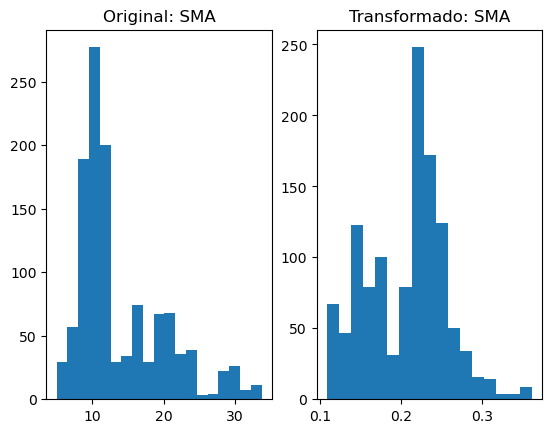

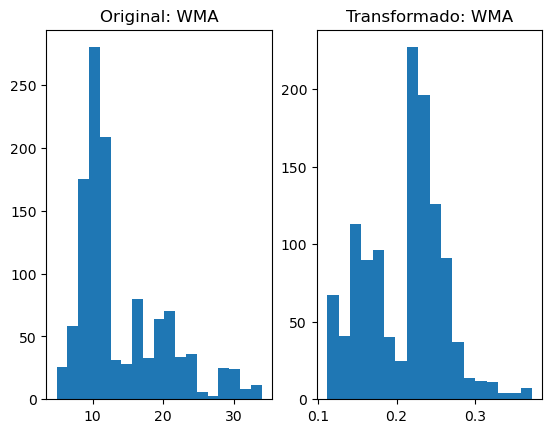

ValueError: cannot convert float NaN to integer

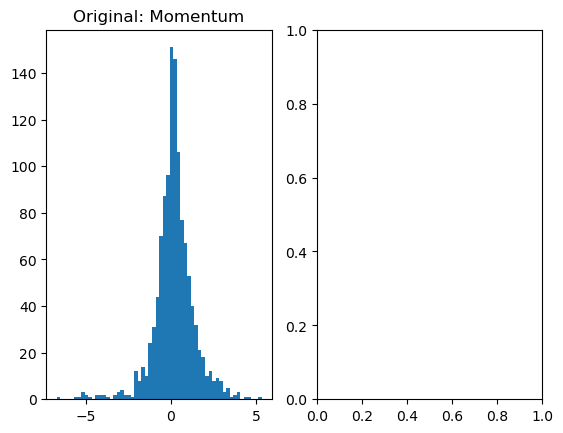

In [9]:
# Exemplo: mostrar histogramas antes e depois da transformação para cada coluna
import matplotlib.pyplot as plt

for idx in range(len(dados.columns)-1):
    col = dados.columns[idx]

    plt.subplot(1, 2, 1)
    plt.hist(dados[col], bins=determina_bins(dados[col]))
    plt.title(f'Original: {col}')
    plt.subplot(1, 2, 2)
    plt.hist(dados_transformados[col], bins=determina_bins(dados_transformados[col]))
    plt.title(f'Transformado: {col}')
    plt.show()

In [10]:
dados_transformados.isna().sum()

SMA              0
WMA              0
Momentum       476
StochasticD     19
StochasticK     68
Williams       157
RSI              0
MACD           404
ADO            160
CCI            182
dtype: int64

TODO: resolver a questão de dados na após a transformação!

## 3. Cálculo da *Mutual Information*

Calculo da *Mutual Information* por meio do hitograma. A forma de definir o número de bins pode ser escolhido entre os métodos Classico, Struges, Scoot e Freedman-Diaconis.

In [ ]:
def calc_mi(x, y, bins_rule='classic'):
    '''Calcula a Mutual Information entre duas variáveis x e y usando histogramas.
    Parâmetros:
    x: array-like, primeira variável.
    y: array-like, segunda variável.
    bins_rule: str, regra para determinar o número de bins. Opções: 'classic', 'sturges', 'scott', 'fd'.
    Retorna:
    mi: float, valor da Mutual Information.
    '''

    bins_x = determina_bins(x, bins_rule)
    bins_y = determina_bins(y, bins_rule)

    hist2d, x_edges, y_edges = np.histogram2d(x, y, bins=[bins_x, bins_y])

    hist2d_norm = hist2d / np.sum(hist2d)

    hist_x = np.sum(hist2d_norm, axis=1)
    hist_y = np.sum(hist2d_norm, axis=0)

    entropia_x = -sum(hist_x[hist_x > 0] * np.log(hist_x[hist_x > 0]))
    entropia_y = -sum(hist_y[hist_y > 0] * np.log(hist_y[hist_y > 0]))

    entropia_conjunta = -sum(hist2d_norm[hist2d_norm > 0] * np.log(hist2d_norm[hist2d_norm > 0]))

    mi = entropia_x + entropia_y - entropia_conjunta

    return mi

**Dúvida:** Na minha cabeça faz mais sentido colocar os os métodos de determinação da bin como entrada, pode ser assim?

Testes da Mutual Information

In [ ]:
colunas = dados.columns[:-1]
bins_rule = ['classic', 'sturges', 'scott', 'fd']

print(f'    Dado     | {bins_rule[0]} | {bins_rule[1]} |  {bins_rule[2]}  |  {bins_rule[3]}')
print('-------------|---------|---------|---------|--------')
for idx, col in enumerate(colunas):
    bins_list = []
    for br in bins_rule:
        bins_list.append(calc_mi(dados[col], dados['rendimento'], bins_rule=br))
    print(f'{col.ljust(13)}|  {bins_list[0]:.3f}  |  {bins_list[1]:.3f}  |  {bins_list[2]:.3f}  |  {bins_list[3]:.3f}')


## 3. Hilbert-Schmidt Independence Criterion (HSIC)

In [ ]:
from sklearn.metrics.pairwise import rbf_kernel

def calc_hsic(x, y, sigma_x = None, sigma_y = None):

    x = np.asarray(x)
    y = np.asarray(y)

    len_x = len(x)

    H = np.eye(len_x) - np.ones((len_x, len_x))/len_x

    if sigma_x is None:
        sigma_x = np.median(np.abs(x[:, None] - x[None, :]))

    if sigma_y is None:
        sigma_y = np.median(np.abs(y[:, None] - y[None, :]))

    K = rbf_kernel(x.reshape(-1, 1), gamma=1/(2*sigma_x**2))
    L = rbf_kernel(y.reshape(-1, 1), gamma=1/(2*sigma_y**2))

    return np.trace(H @ K @ H @ L) / (len_x - 1)**2

**Dúvida:** Na minha cabeça faz mais sentido calcular o sigma para os dados inseridos, pode ser assim?

Teste da HSIC

In [ ]:
colunas = dados.columns[:-1]

print(f'    Dado     | HSIC')
print('-------------|---------')
for idx, col in enumerate(colunas):
    hsic = calc_hsic(dados[col], dados['rendimento'])
    print(f'{col.ljust(13)}|  {hsic:.5f}')

## 4. Modelo

Definir os dados a serem usados e separar em treino, validação e teste

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

Separa os **Dados Iniciais** em treino, validação e teste

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(dados[dados.columns[:-1]], dados['rendimento'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

Separa os **Dados em Bins** em Treino, Validação e Teste 

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(dados_bins[dados_bins.columns[:-1]], dados_bins['rendimento'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

### 4.1 xgBoost

In [ ]:
from xgboost import XGBRegressor
import xgboost

In [ ]:
model = XGBRegressor()
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
mse_train = mean_squared_error(y_train, y_pred_train)
print(f'MSE Treino: {mse_train:.4f}')

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'MSE Teste: {mse:.4f}')

In [ ]:
xgboost.plot_importance(model)

In [ ]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

### 4.2 LightGBM

In [ ]:
import lightgbm as lgb

train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

In [ ]:
params = {
    'objective': 'regression',
    'metric': 'mse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'verbose': -1
}
num_round = 100
bst = lgb.train(params, train_data, num_round, valid_sets=[val_data])
y_pred_train_val = bst.predict(X_train_val, num_iteration=bst.best_iteration)
mse_train_val = mean_squared_error(y_train_val, y_pred_train_val)
print(f'LightGBM Train+Val MSE: {mse_train_val:.3f}')

y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)
mse = mean_squared_error(y_test, y_pred)
print(f'LightGBM Teste MSE: {mse:.3f}')



In [ ]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)